ZebraFish Haemoglobin protein and Phenyl Hydrazine Complex
======================


## ``Gromacs_py`` simulation

Here is an example of a short simulation of the Zebrafish Haemoglobin (`zeb_hb`) protein in complex with phenyl hydrazine (`phz`) ligand using AMBER force-field model.

**TODO:** Need to do this to properly docked system. The PDB file of ligand must be generated from the canonical SMILES by rdkit. This can be done locally using:

```python
>>> lig_name = 'phz'
>>> lig_resname = lig_name.upper()
>>> gmx.gmxsys.ambertools.smile_to_pdb("C1=CC=C(C=C1)NN",os.path.join(DATA_OUT,f"{lig_name}.pdb"),lig_resname)
```

After that, dock it with protein using `AMDock` via `Autodock Vina`. Cut-paste the protein and ligand parts from the complex PDB and save separately. Then, reload the ligand PDB into pymol and add hydrogen atoms everywhere.


Finally, eight successive steps are used:

1. Load the protein in its best -docked state. Docking performed externally using Autodock Vina through `AMDock` GUI.
   
2. In-complex creation of Protein Topology using ``GmxSys.add_top()``, followed by boxing and solvation/neutralization.
   
3. Boxing of complex.
   
4. Ideallt, Ligand topology creation using `prepare_top()` which uses `acpype` to build ligand topology. This did not work, so must do this manually using `acpype` externally
   
5. Solvate complex and add ions.

6. Minimisation of the structure using ``GmxSys.em_2_steps()``.

7. **TODO:** Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.

8. **TODO:** Production run using ``GmxSys.production()``.

### Import

In [1]:
import sys
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## To use `gromacs_py` in a project

In [2]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
  
    1. simulation output folders
    2. ionic concentration
    3. number of minimisation steps
    4. equilibration and production time

### Regarding equilibriation time:
The following variables define the sim times (relative units) for each stage of the three-stage equilibriation process. Check notes below for details:

1. `HA_time`
2. `CA_time`
3. `CA_LOW_time` 


In [3]:
DATA_OUT = 'zeb_hb_phz_complex_sim'

# System Setup
vsite='none'
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')
#ignore_hydrogen = {'ignh': None}

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000
emtol = 10.0  	# Stop minimization when the maximum force < 10 J/mol
emstep  = 0.01      # Energy step size


# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 4.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 100.0

prod_step = 1000 * prod_time / dt

## Create the `GmxSys` object

Load protein information only from docked PDB file on disk

In [4]:
pdb_file = "zeb_hb_phz_docking_20240912/final_pdbs/zeb_hb_docked_complex.pdb"
sys_name = "zeb_hb_phz_complex"
complex_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

## Create topology and stuff

1. Topology creation involves using `pdb2gmx` via the `prepare_top()` function.
2. Create box



In [5]:
complex_sys.prepare_top(out_folder=DATA_OUT, ff='amber99sb-ildn')

pdb2pqr30 --ff AMBER --ffout AMBER --keep-chain --titration-state-method=propka --with-ph=7.00 tmp_pdb2pqr.pdb 00_zeb_hb_phz_complex.pqr
gmx pdb2gmx -f 01_zeb_hb_phz_complex_good_his.pdb -o zeb_hb_phz_complex_pdb2gmx.pdb -p zeb_hb_phz_complex_pdb2gmx.top -i zeb_hb_phz_complex_posre.itp -water tip3p -ff amber99sb-ildn -ignh -vsite none


## Create Ligand topology and transclude manually to complex topology

Doing this automatically in `gromacs_py` is buggy and doesn't work, necessitating manual overrides.

1. First, you need to add ALL hydrogen atoms into the PDF file of the best-docked ligand pose using pymol. 
2. Then run `acpype -i` on the resultant PDB from shell. These yield full ligand topology for multiple force fields. We're using the default AMBER force field here.

3. Next, copy-paste the contents of the ligand's amber force field topology file transclusions to the top of the complex topology file, AND the molecules section of the ligand's topology file to the molecules section of the complex topology file. 

**Note:** The ligand information MUST come FIRST in the complex topology, as there are new atomtypes in there and those must be defined first before any `moleculetype`. [See this](https://gromacs.bioexcel.eu/t/invalid-order-for-directive-atomtypes-error/3859)

4. Make sure to adjust the paths of all transcluded files.

5. Finally, update the complex PDB file with ligand co-ordinates from the best-docked pose using `pymol`.


In [6]:
complex_sys.display()

name         : zeb_hb_phz_complex
coor_file    : zeb_hb_phz_complex_sim/zeb_hb_phz_complex_pdb2gmx.pdb
top_file     : zeb_hb_phz_complex_sim/zeb_hb_phz_complex_pdb2gmx.top
nt           : 0
ntmpi        : 0
sys_history  : 0


In [7]:
complex_sys.create_box(dist=1.5, box_type="dodecahedron", check_file_out=True)
complex_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name,create_box_flag=False, maxwarn=4)
complex_sys.display()

gmx editconf -f zeb_hb_phz_complex_sim/zeb_hb_phz_complex_pdb2gmx.pdb -o zeb_hb_phz_complex_sim/zeb_hb_phz_complex_pdb2gmx_box.pdb -bt dodecahedron -d 1.5
gmx grompp -f ../../../../../../usr/local/miniforge3/envs/mdanalysis/lib/python3.12/site-packages/gromacs_py/gmx/template/mini.mdp -c zeb_hb_phz_complex_water.pdb -r zeb_hb_phz_complex_water.pdb -p zeb_hb_phz_complex_water_ion.top -po out_mini.mdp -o genion_zeb_hb_phz_complex_water_ion.tpr -maxwarn 4
gmx genion -s genion_zeb_hb_phz_complex_water_ion.tpr -p zeb_hb_phz_complex_water_ion.top -o zeb_hb_phz_complex_water_ion.gro -np 28 -pname NA -nn 29 -nname CL
name         : zeb_hb_phz_complex
sim_name     : genion_zeb_hb_phz_complex_water_ion
coor_file    : zeb_hb_phz_complex_sim/zeb_hb_phz_complex_water_ion.gro
top_file     : zeb_hb_phz_complex_sim/zeb_hb_phz_complex_water_ion.top
tpr          : zeb_hb_phz_complex_sim/genion_zeb_hb_phz_complex_water_ion.tpr
mdp          : ../../../../../usr/local/miniforge3/envs/mdanalysis/lib/python3

## Energy minimisation

Set parallelization and GPU options here. Change them later, if needed.

In [8]:
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.em_2_steps(out_folder=em_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        posres="",
        create_box_flag=False, emtol=emtol, emstep=emstep)

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file Init_em_zeb_hb_phz_complex.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file Init_em_zeb_hb_phz_complex.mdp


gmx grompp -f Init_em_zeb_hb_phz_complex.mdp -c ../zeb_hb_phz_complex_water_ion.gro -r ../zeb_hb_phz_complex_water_ion.gro -p ../zeb_hb_phz_complex_water_ion.top -po out_Init_em_zeb_hb_phz_complex.mdp -o Init_em_zeb_hb_phz_complex.tpr -maxwarn 1
gmx mdrun -s Init_em_zeb_hb_phz_complex.tpr -deffnm Init_em_zeb_hb_phz_complex -nt 12 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file zeb_hb_phz_complex.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file zeb_hb_phz_complex.mdp


gmx grompp -f zeb_hb_phz_complex.mdp -c Init_em_zeb_hb_phz_complex.gro -r Init_em_zeb_hb_phz_complex.gro -p ../zeb_hb_phz_complex_water_ion.top -po out_zeb_hb_phz_complex.mdp -o zeb_hb_phz_complex.tpr -maxwarn 1
gmx mdrun -s zeb_hb_phz_complex.tpr -deffnm zeb_hb_phz_complex -nt 12 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

## Plot energy:

In [9]:
ener_pd_1 = complex_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = complex_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

gmx energy -f zeb_hb_phz_complex_sim/em/Init_em_zeb_hb_phz_complex.edr -o tmp_edr.xvg
gmx energy -f zeb_hb_phz_complex_sim/em/zeb_hb_phz_complex.edr -o tmp_edr.xvg


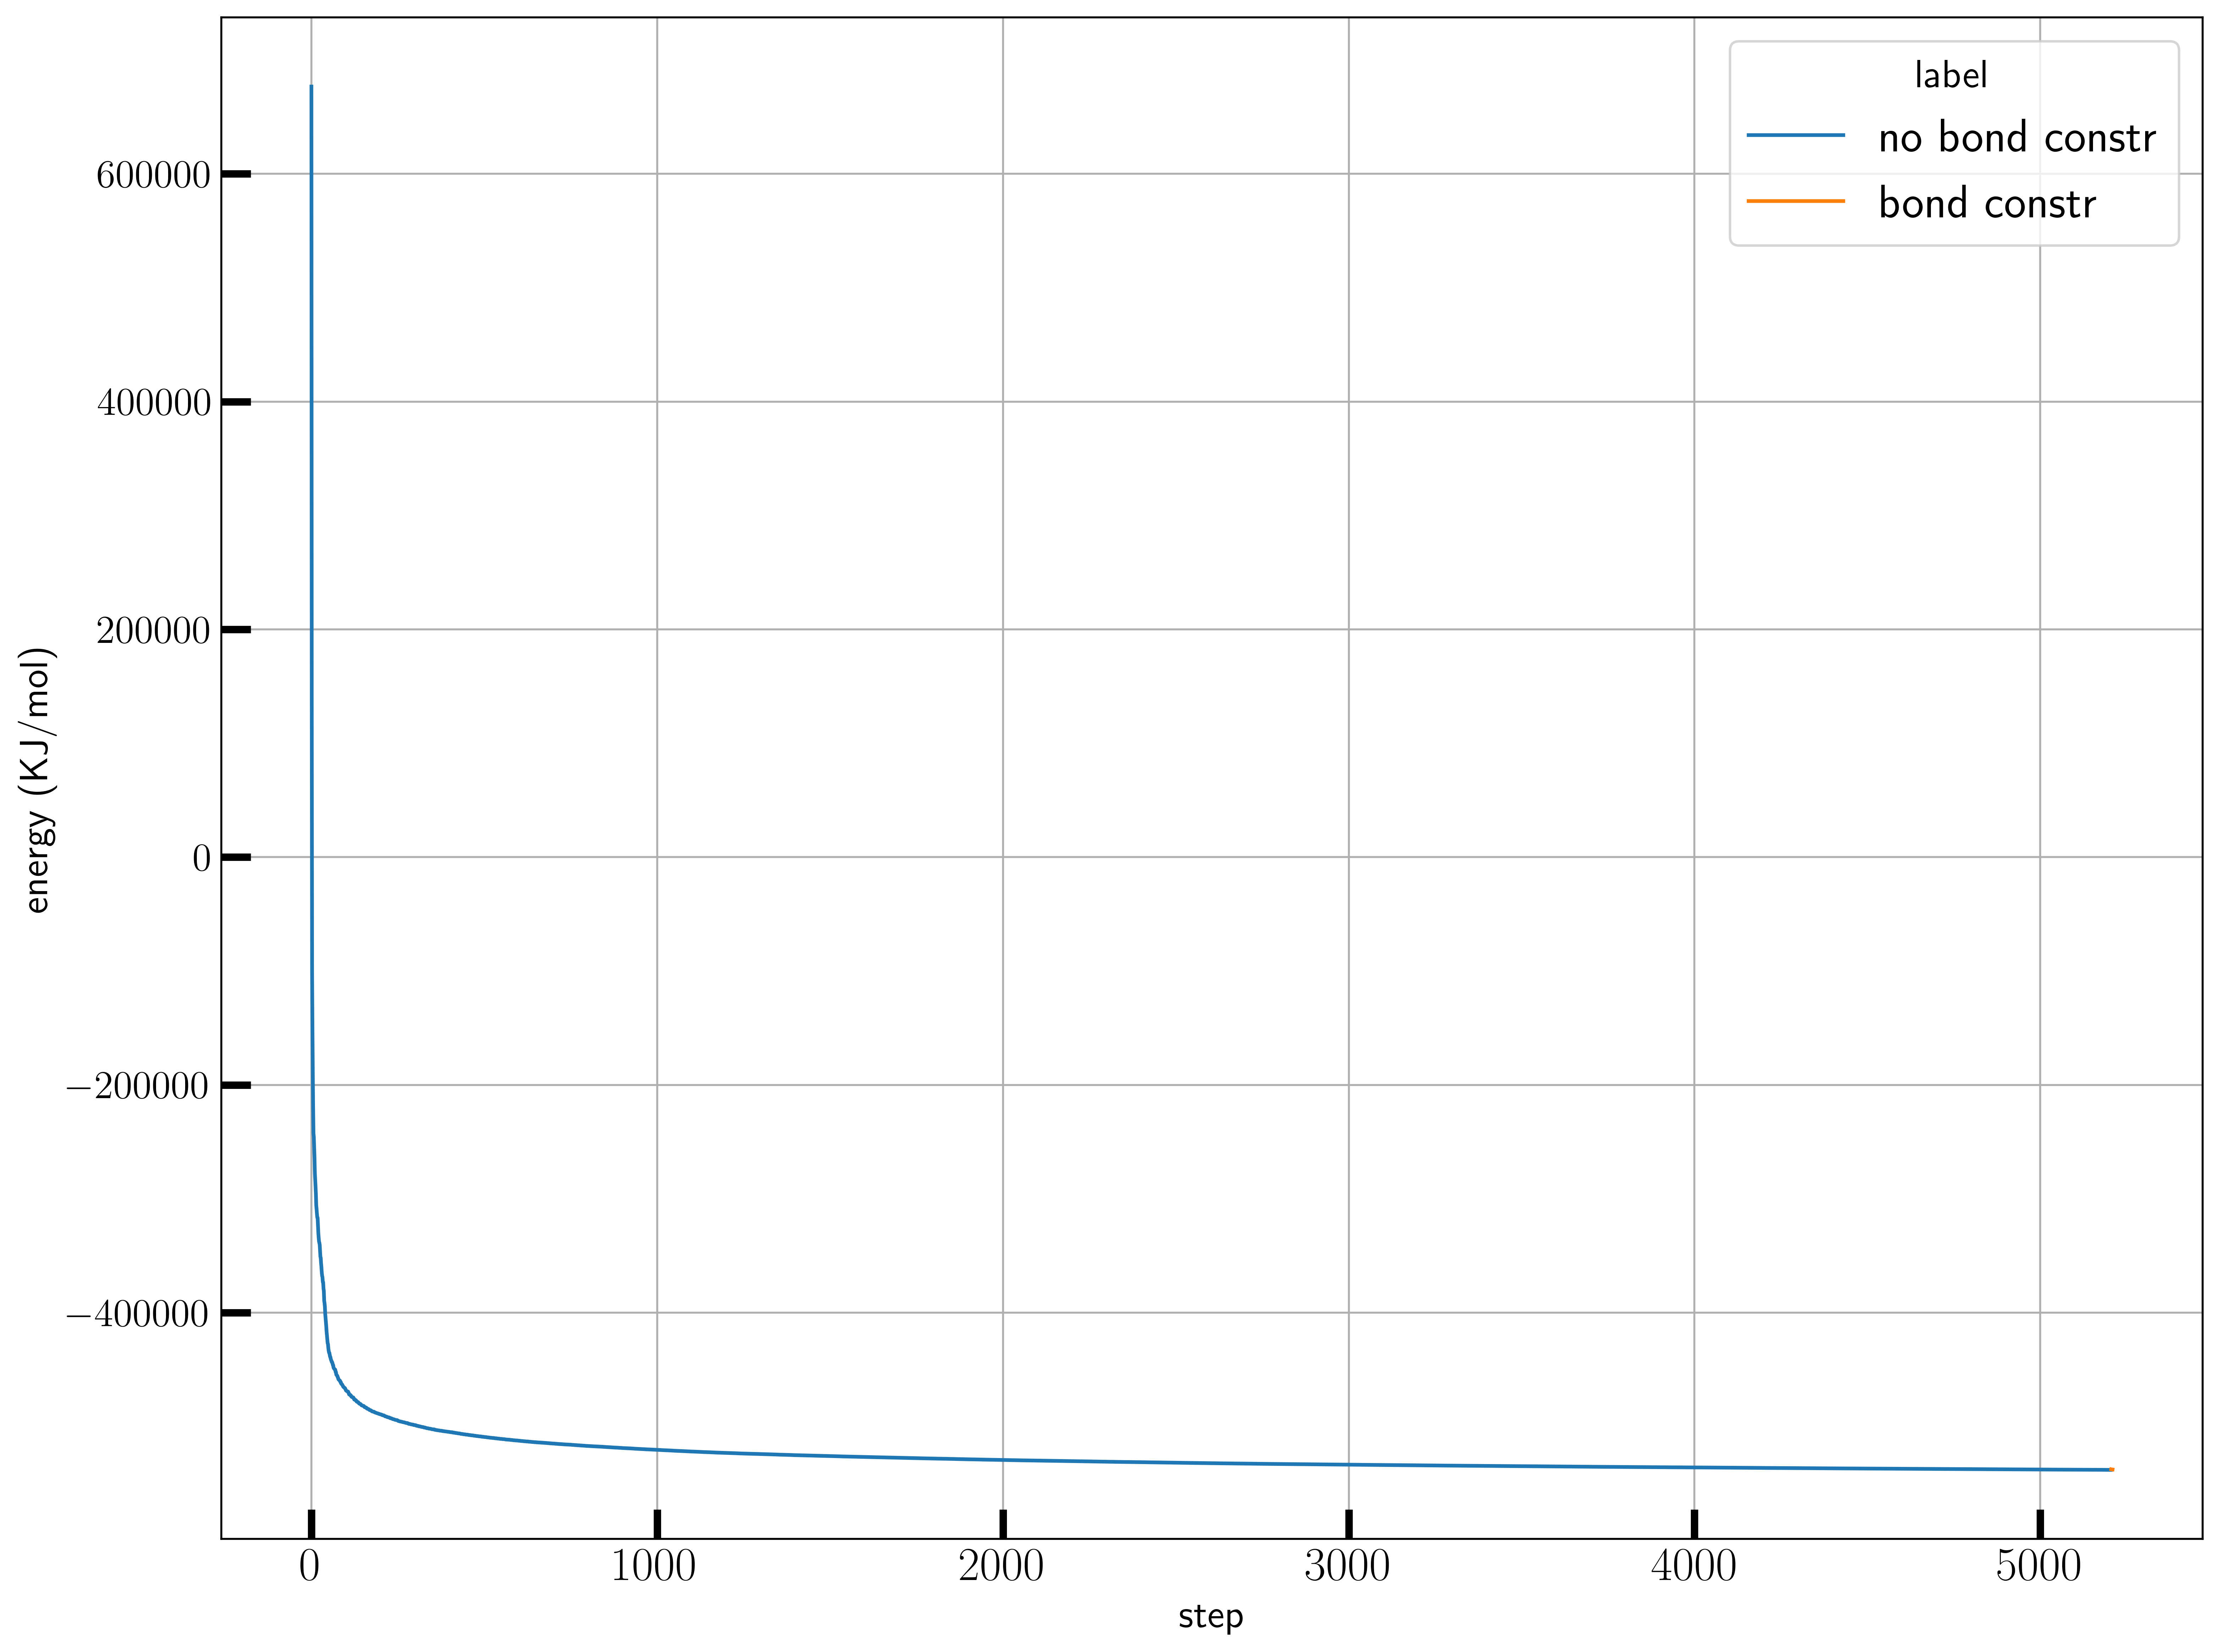

In [10]:
ax = sns.lineplot(x="Time (ps)", y="Potential",
        hue="label",
        data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

### Checkpoint using pickles. Restore and run from cluster

In [11]:
import pickle

with open('checkpoint_em_20240915.pycpt', 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## From here, run in cluster
### System minimisation and equilibration

Based on `gromacs_py` docs, this is a 3-stage equilibriation process. 

All three steps seem to be NPT with berendsen coupling and v-rescale for temp coupling. Each step just has different restraints. This does not seem so bad: closer to lab conditions.

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/).

**Note:** 
1. Had to run this on param at least. Too slow even in ofc workstn.
2. Temperature coupling groups have to be set properly. See [mdtutorials](http://www.mdtutorials.com/gmx/complex/06_equil.html) and [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#System-equilibration)
3. Ligand name is `HZ1` (presumably malformatted from `PHZ1`) as seen in the index file by visual inspection.

In [ ]:
complex_sys.em_equi_three_step_iter_error(out_folder=equi_folder,
    no_constr_nsteps=em_step_number,
    constr_nsteps=em_step_number,
    nsteps_HA=HA_step,  
    nsteps_CA=CA_step,
    nsteps_CA_LOW=CA_LOW_step,
    dt=dt, dt_HA=dt_HA,
    tc_grps='Protein HZ1 Water_and_ions',
    tau_t= '0.1 0.1 0.1',
    ref_t= '310 310 310',
    vsite=vsite, maxwarn=10, iter_num=1)

In [ ]:
complex_sys.sys_history[-2].display()

### Plot Equilibriation

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/). So we need to see Volume as well as Pressure, temperature, and density.

In [ ]:
quantities = ["Temperature", "Pressure", "Volume", "Density"]
units = ["$K$", "$bar$", "$A^3$", "$kg/m^3$"]

pd_1 = complex_sys.sys_history[-2].get_ener(selection_list=quantities)
pd_2 = complex_sys.sys_history[-1].get_ener(selection_list=quantities)
pd_3 = complex_sys.get_ener(selection_list=quantities)

pd_1['label'] = 'HA_constr'
pd_2['label'] = 'CA_constr'
pd_2['Time (ps)'] = pd_2['Time (ps)'] + pd_1['Time (ps)'].max()
pd_3['label'] = 'CA_LOW_constr'
pd_3['Time (ps)'] = pd_3['Time (ps)'] + pd_2['Time (ps)'].max()

display(pd.concat([pd_1, pd_2, pd_3]))

In [ ]:
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(4, 1, figsize=(24,13.5), sharex=True, tight_layout=True)

for ax, quantity, unit in zip(axs, quantities, units):
    for df in (pd_1, pd_2, pd_3):
        ax.plot(df["Time (ps)"], df[quantity], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        ax.grid()

axs[0].legend()
axs[-1].set_xlabel("Time (ps)");

Looks okay to me. Fluctuations are high at the end because CA constraints are low, but there is a well-defined average.

Alternatively, we **could** not do the `CA_LOW_constr` part.

### Plot RMSD

In [ ]:
# Define reference structure for RMSD calculation
ref_sys =  md_sys.sys_history[1]

struct="Protein"

rmsd_pd_1 = md_sys.sys_history[-2].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_2 = md_sys.sys_history[-1].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_3 = md_sys.get_rmsd([struct, struct], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

display(pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3]))


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24,13.5))

for df in (rmsd_pd_1, rmsd_pd_2, rmsd_pd_3):
        ax.plot(df["time"], df["Protein"], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        
ax.set_title(struct)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Checkpointing

Checkpoint using pickling. This will be easier to restore in the cluster

In [ ]:
import pickle

with open('checkpoint_equi.pycpt', 'wb') as py_cpt:
    pickle.dump(md_sys, py_cpt)

## Production MD 

tc-coupling groups are required here as well. See [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#Production)

In [ ]:
md_sys.production(out_folder=prod_folder,
        nsteps=prod_step,tc_grps='Protein HZ1 Water_and_ions',
        tau_t= '0.1 0.1 0.1',
        ref_t= '310 310 310',
        dt=dt, vsite=vsite, maxwarn=1)


## Checkpointing Again


In [ ]:
import pickle

with open('checkpoint_prod.pycpt', 'wb') as py_cpt:
    pickle.dump(md_sys, py_cpt)

## Post-Production

### Prepare trajectory

In [ ]:
# Center trajectory
md_sys.center_mol_box(traj=True)

### Trajectory Conversion for better viewing

In [ ]:
# Align the protein coordinates
md_sys.convert_trj(select='Protein\nSystem\n', fit='rot+trans', pbc='none', skip='10')

In [ ]:
md_sys.display_history()